In [1]:
from pathlib import Path
import importlib
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from pandera.typing import DataFrame

import tidalsim.modeling.extrapolation as tme
from tidalsim.util.pickle import load
from tidalsim.modeling.schemas import EstimatedPerfSchema, GoldenPerfSchema
importlib.reload(tme)

<module 'tidalsim.modeling.extrapolation' from '/scratch/vighneshiyer/chipyard-tidalsim/tools/tidalsim/tidalsim/modeling/extrapolation.py'>

In [2]:
def make_arrays_equal_size(arr1, arr2):
    if len(arr1) > len(arr2):
        return arr1[:len(arr2)], arr2
    else:
        return arr1, arr2[:len(arr1)]
        
def reconstruct_ipc_trace(workload: str, interval_length: int, clusters: int, detailed_warmup_insts: int) -> DataFrame[EstimatedPerfSchema]:
    cluster_dir = Path.cwd().parent / "runs" / workload / f"n_{interval_length}_spike" / f"c_{clusters}" 
    clustering_df = load(cluster_dir / "clustering_df.pickle")
    estimated_perf_df = tme.fill_perf_metrics(clustering_df, cluster_dir, detailed_warmup_insts)
    rows_with_data = estimated_perf_df
    ipcs_warm = estimated_perf_df.sort_values('cluster_id').groupby('cluster_id')['est_ipc_warm'].max().to_numpy()
    ipcs_cold = estimated_perf_df.sort_values('cluster_id').groupby('cluster_id')['est_ipc_cold'].max().to_numpy()
    cluster_ids = estimated_perf_df['cluster_id'].to_numpy()
    estimated_perf_df = estimated_perf_df.assign(
        est_ipc_warm = ipcs_warm[cluster_ids],
        est_ipc_cold = ipcs_cold[cluster_ids]
    )
    return estimated_perf_df

def golden_ipc_trace(workload: str) -> Optional[DataFrame[GoldenPerfSchema]]:
    workload_dir = Path.cwd().parent / "runs" / workload / "golden"
    if not (workload_dir / "perf.csv").exists():
        return None
    else:
        return tme.parse_golden_perf(workload_dir / "perf.csv")

In [4]:
workload = "wikisort"
interval_length = 10000
clusters = 18
detailed_warmup_insts = 2000

tidalsim_df = reconstruct_ipc_trace(workload, interval_length, clusters, detailed_warmup_insts)
golden_df = golden_ipc_trace(workload)
display(tidalsim_df)
if golden_df is not None:
    y_true, y_pred = make_arrays_equal_size(tidalsim_df.est_ipc_warm, golden_df.ipc)
    ipc_mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"IPC MAPE: {ipc_mape}")
    ipc_abs_error_trace = np.abs((y_true - y_pred) / y_true)

,instret,inst_count,inst_start,embedding,cluster_id,dist_to_centroid,chosen_for_rtl_sim,est_ipc_cold,est_ipc_warm
0,10000,10000,0,"[0.01950346331612503, 0.0004589050192029419, 0...",7,0.682459,False,0.763286,0.886132
1,10000,20000,10000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.074614,False,0.738894,0.871840
2,10000,30000,20000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.240763,False,0.633613,0.748713
3,10000,40000,30000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,0.146664,False,0.658003,0.733071
4,10000,50000,40000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.118990,False,0.633613,0.748713
...,...,...,...,...,...,...,...,...,...
183,10000,1840000,1830000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.101745,False,0.633613,0.748713
184,10000,1850000,1840000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,0.355945,False,0.687521,0.886132
185,10000,1860000,1850000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.120336,False,0.685401,0.771903
186,10000,1870000,1860000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.082570,True,0.685401,0.771903


IPC MAPE: 0.04506810343043729


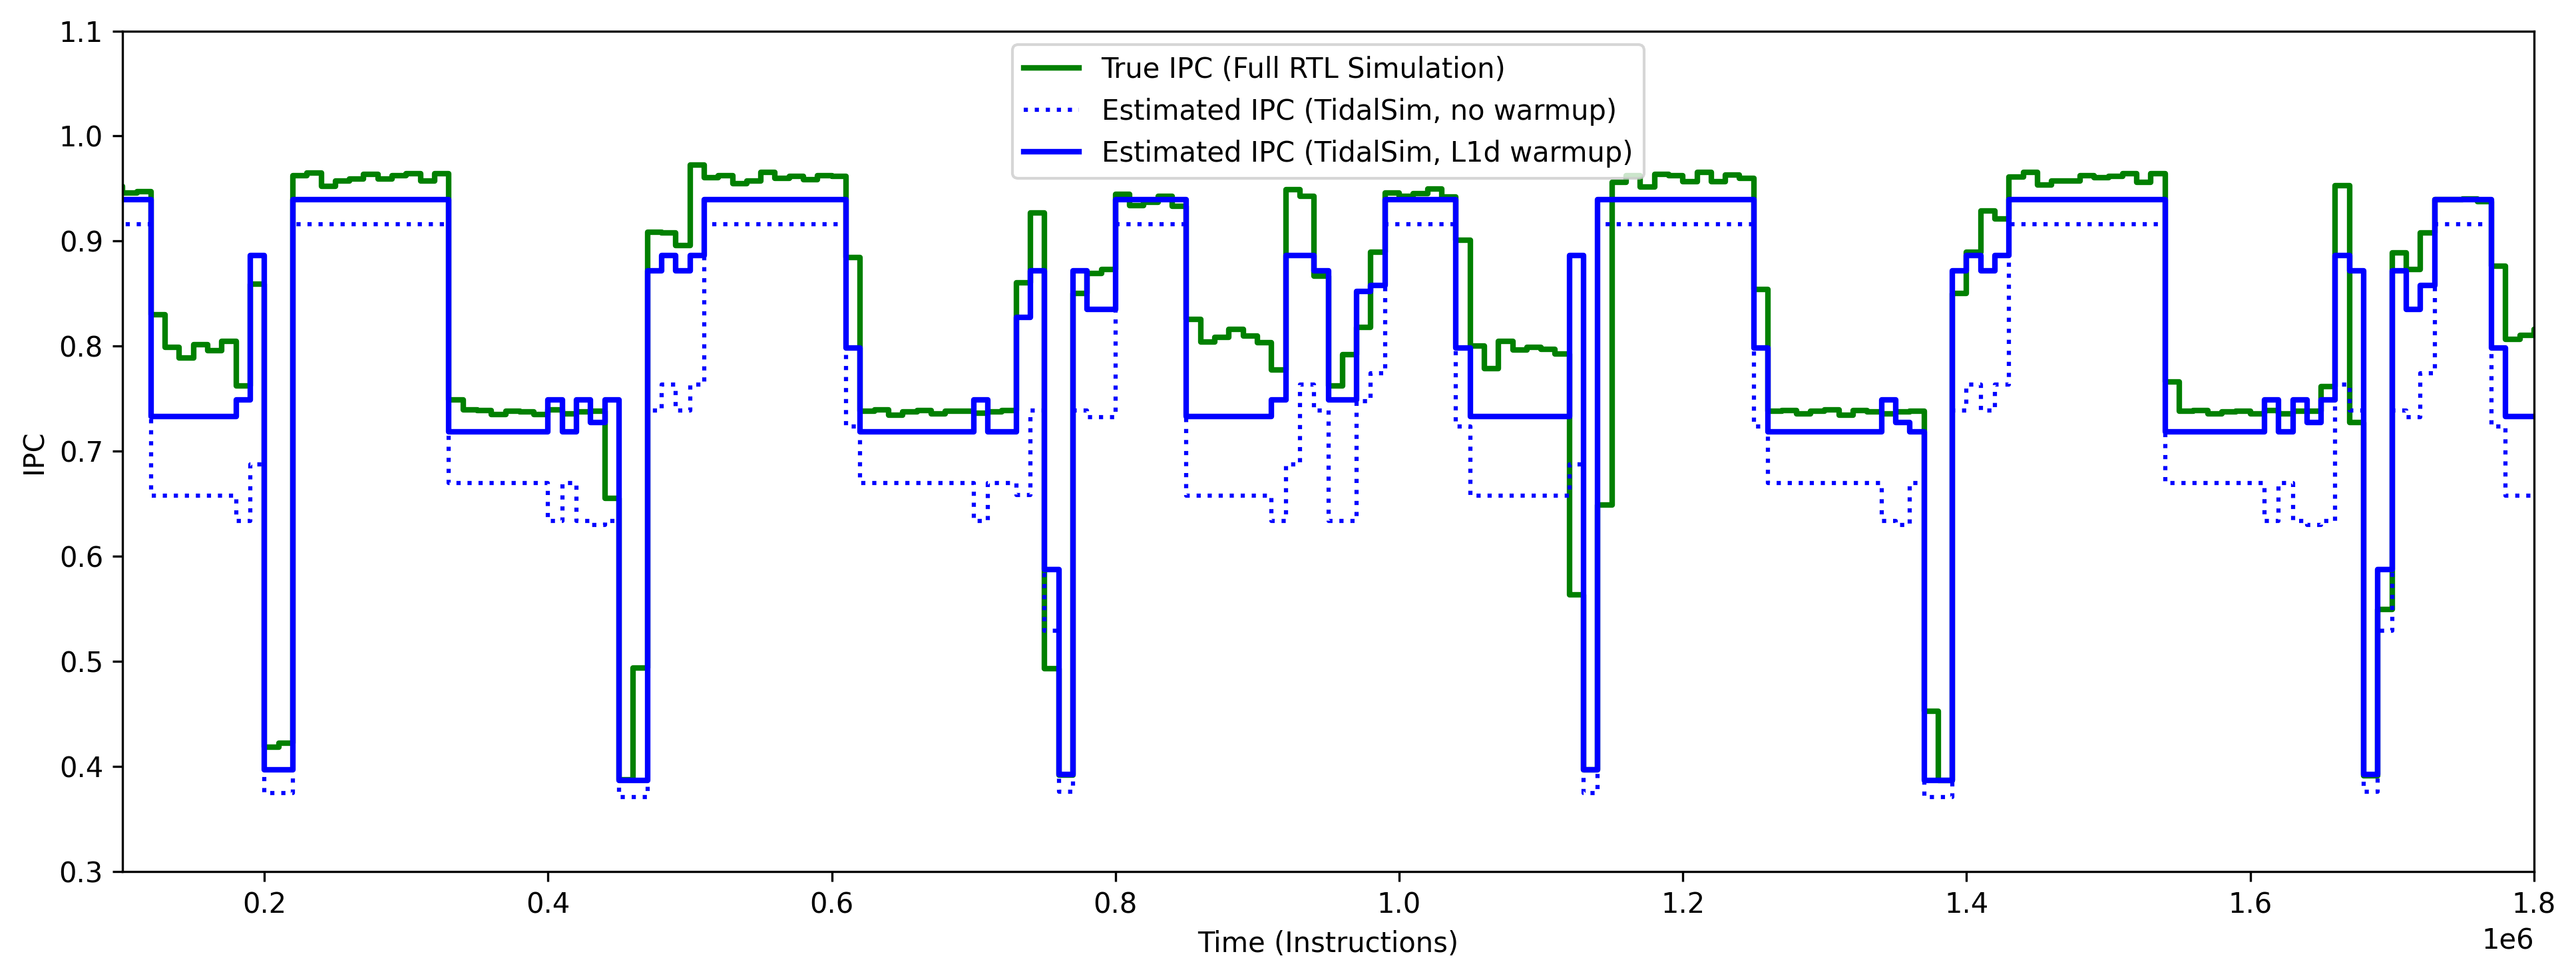

In [5]:
# https://stackoverflow.com/questions/37737538/merge-subplots-with-shared-x-axis
# https://matplotlib.org/stable/gallery/spines/multiple_yaxis_with_spines.html

fig, ax1 = plt.subplots(1, 1)

if golden_df is not None:
    p3, = ax1.step(golden_df.inst_count, golden_df.ipc, "g", linewidth=2, label="True IPC (Full RTL Simulation)")
p1, = ax1.step(tidalsim_df.inst_count, tidalsim_df.est_ipc_cold, "b", linestyle='dotted', label="Estimated IPC (TidalSim, no warmup)")
p2, = ax1.step(tidalsim_df.inst_count, tidalsim_df.est_ipc_warm, "b", linewidth=2, label="Estimated IPC (TidalSim, L1d warmup)")
ax1.set_xlim([0.1e6, 1.8e6])
ax1.set_ylim([0.3, 1.1])
ax1.set_ylabel('IPC')
ax1.set_xlabel('Time (Instructions)')
ax1.legend()
fig.set_size_inches(13, 5)
plt.tight_layout()
plt.savefig('wikisort.svg')

/scratch/vighneshiyer/chipyard/.conda-env/lib/python3.10/site-packages/numpy/lib/shape_base.py:379: RuntimeWarning: divide by zero encountered in log
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/scratch/vighneshiyer/chipyard/.conda-env/lib/python3.10/site-packages/numpy/lib/shape_base.py:379: RuntimeWarning: invalid value encountered in log
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/scratch/vighneshiyer/chipyard/.conda-env/lib/python3.10/site-packages/numpy/lib/shape_base.py:402: RuntimeWarning: divide by zero encountered in log
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
/scratch/vighneshiyer/chipyard/.conda-env/lib/python3.10/site-packages/numpy/lib/shape_base.py:402: RuntimeWarning: invalid value encountered in log
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


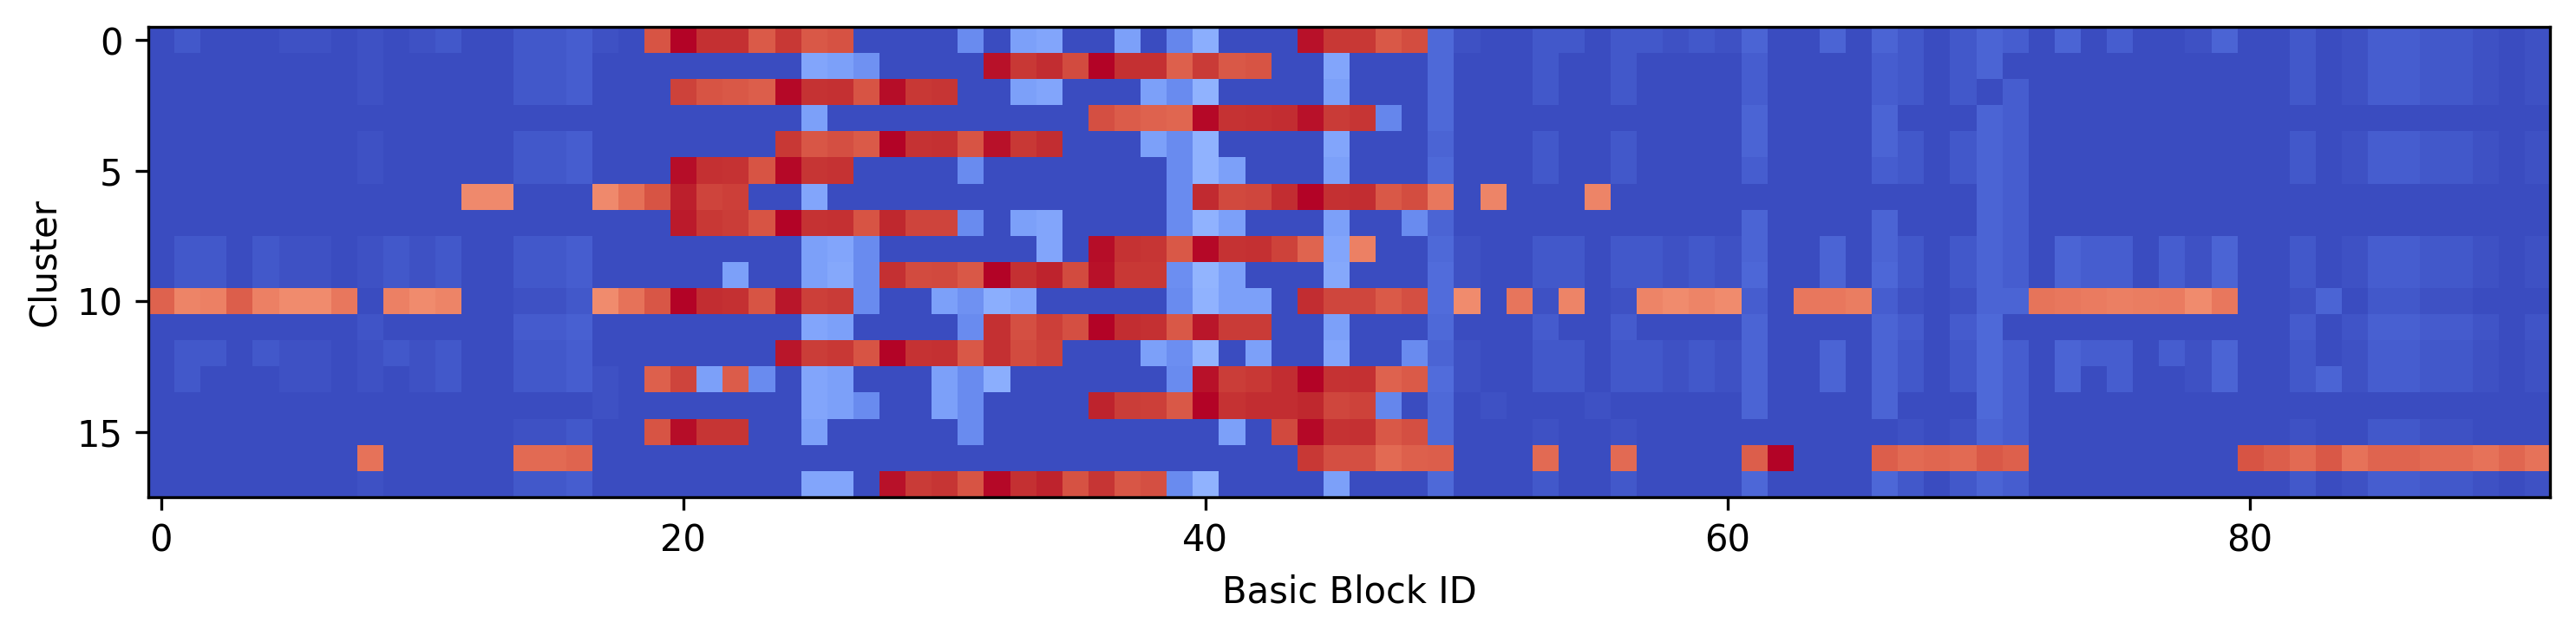

In [9]:
kmeans = load(Path('/scratch/vighneshiyer/chipyard/tools/tidalsim/runs/aha-mont64-fb8c96bc/n_1000_spike/c_18/kmeans_model.pickle'))
centers = np.apply_along_axis(np.log, 1, kmeans.cluster_centers_)
fig, ax = plt.subplots()

import matplotlib as mpl
cmap = mpl.colormaps.get_cmap('coolwarm')
cmap.set_bad(color=cmap(0))

cmap = ax.imshow(centers, cmap=cmap, interpolation='nearest')
ax.set_xlabel('Basic Block ID')
ax.set_ylabel('Cluster')
plt.subplots_adjust(hspace=.0)
fig.set_size_inches(10, 3)
plt.tight_layout()
plt.savefig('aha-mont64_clustering.svg', bbox_inches='tight')